# Relax - Data Science Take Home Challenge

### Part 1 - Exploratory Data Analysis

A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years. This  table  includes:

    ● name:  the  user's  name
    ● object_id:   the  user's  id
    ● email:  email  address
    ● creation_source:   how  their  account  was  created.  This  takes  on  one of  5  values:
        ○ PERSONAL_PROJECTS:  invited  to  join  another  user's
        personal  workspace
        ○ GUEST_INVITE:  invited  to  an  organization  as  a  guest (limited  permissions)
        ○ ORG_INVITE:  invited  to  an  organization  (as  a  full  member)
        ○ SIGNUP:  signed  up  via  the  website
        ○ SIGNUP_GOOGLE_AUTH:  signed  up  using  Google Authentication  (using  a  Google  email  account  for  their  
        login id)
    ● creation_time:  when  they  created  their  account
    ● last_session_creation_time:   unix  timestamp  of  last  login
    ● opted_in_to_mailing_list:  whether  they  have  opted  into  receiving marketing  emails
    ● enabled_for_marketing_drip:  whether  they  are  on  the  regular marketing  email  drip
    ● org_id:   the  organization  (group  of  users)  they  belong  to
    ● invited_by_user_id:   which  user  invited  them  to  join  (if  applicable).

A  usage  summary  table  ( "takehome_user_engagement" )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# plot setting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)})

In [4]:
## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

#### Reading in our Data and doing initial EDA

In [5]:
# Reading in the files
relax = pd.read_csv('takehome_users.csv', encoding = "latin1", parse_dates=True, index_col = 'creation_time')
relax.head()

,object_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_time,,,,,,,,,
2014-04-22 03:53:30,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2013-11-15 03:45:04,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2013-03-19 23:14:52,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
2013-05-21 08:09:28,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
2013-01-17 10:14:20,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
relax_engagement = pd.read_csv('takehome_user_engagement.csv', encoding = "latin1", parse_dates=['time_stamp'])
relax_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# Renaming object_id column to user_id column to match the other csv file
relax = relax.rename({'object_id': 'user_id'}, axis=1)
relax.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_time,,,,,,,,,
2014-04-22 03:53:30,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2013-11-15 03:45:04,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2013-03-19 23:14:52,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
2013-05-21 08:09:28,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
2013-01-17 10:14:20,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
relax.dropna(subset = ['last_session_creation_time'], inplace=True)
relax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8823 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     8823 non-null   int64  
 1   name                        8823 non-null   object 
 2   email                       8823 non-null   object 
 3   creation_source             8823 non-null   object 
 4   last_session_creation_time  8823 non-null   float64
 5   opted_in_to_mailing_list    8823 non-null   int64  
 6   enabled_for_marketing_drip  8823 non-null   int64  
 7   org_id                      8823 non-null   int64  
 8   invited_by_user_id          4776 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 689.3+ KB


In [9]:
# Convert last_session_creation_time to a datetime object
relax['last_session_creation_time'] = pd.to_datetime(relax['last_session_creation_time'], unit='s')
relax.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_time,,,,,,,,,
2014-04-22 03:53:30,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
2013-11-15 03:45:04,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2013-03-19 23:14:52,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
2013-05-21 08:09:28,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
2013-01-17 10:14:20,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [10]:
relax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8823 entries, 2014-04-22 03:53:30 to 2014-01-26 08:57:12
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   name                        8823 non-null   object        
 2   email                       8823 non-null   object        
 3   creation_source             8823 non-null   object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    8823 non-null   int64         
 6   enabled_for_marketing_drip  8823 non-null   int64         
 7   org_id                      8823 non-null   int64         
 8   invited_by_user_id          4776 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 689.3+ KB


In [11]:
relax.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_time,,,,,,,,,
2014-04-22 03:53:30,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
2013-11-15 03:45:04,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2013-03-19 23:14:52,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
2013-05-21 08:09:28,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
2013-01-17 10:14:20,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [12]:
# Index out of order.  Sort index 
relax_si = relax.sort_index()
relax_si

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
creation_time,,,,,,,,,
2012-05-31 00:43:27,3861,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,2012-06-03 00:43:27,0,0,115,3861.0
2012-05-31 01:42:31,11430,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,2012-06-01 01:42:31,0,0,239,5677.0
2012-05-31 06:23:51,7170,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,2012-08-20 06:23:51,0,0,145,7170.0
2012-05-31 08:20:06,10012,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,2012-05-31 08:20:06,0,1,225,7104.0
2012-05-31 11:55:59,11999,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN
...,...,...,...,...,...,...,...,...,...
2014-05-30 23:10:35,6945,Sandoval Matthew,MatthewKSandoval@cuvox.de,SIGNUP,2014-05-31 23:10:35,0,0,5,NaN
2014-05-30 23:12:01,9688,Coveny Taj,TajCoveny@yahoo.com,GUEST_INVITE,2014-06-01 23:12:01,0,0,93,7296.0
2014-05-30 23:27:30,10164,Walsh Sam,SamWalsh@jourrapide.com,GUEST_INVITE,2014-05-30 23:27:30,0,0,302,5383.0


#### Indentify users who logged in more than 3 times in a period of 7 days or less

In [13]:
relax_engagement = relax_engagement.sort_values(by=['time_stamp'])
relax_engagement.head()

,time_stamp,user_id,visited
178140,2012-05-31 08:20:06,10012,1
59486,2012-05-31 15:47:36,3428,1
175638,2012-05-31 17:19:37,9899,1
26821,2012-05-31 21:58:33,1693,1
109716,2012-06-01 00:17:30,6102,1


In [14]:
relax_engagement.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 178140 to 70763
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 6.3 MB


In [15]:
relax_engagement['week'] = relax_engagement['time_stamp'].dt.week
relax_engagement_2 = relax_engagement.groupby(['week','user_id'])['time_stamp'].count().reset_index(name="freq")

frequency = relax_engagement_2[relax_engagement_2.freq >= 3]
frequency

,week,user_id,freq
1,1,10,5
2,1,42,4
5,1,63,7
6,1,69,10
7,1,81,3
...,...,...,...
57164,52,11939,5
57165,52,11957,4
57166,52,11959,3
57169,52,11969,3


In [16]:
relax_engagement['week'] = relax_engagement['time_stamp'].dt.week
relax_engagement['year'] = relax_engagement['time_stamp'].dt.year
relax_engagement.head()

,time_stamp,user_id,visited,week,year
178140,2012-05-31 08:20:06,10012,1,22,2012
59486,2012-05-31 15:47:36,3428,1,22,2012
175638,2012-05-31 17:19:37,9899,1,22,2012
26821,2012-05-31 21:58:33,1693,1,22,2012
109716,2012-06-01 00:17:30,6102,1,22,2012


In [17]:
# Saving a dataframe of users who logged in more than 3 times a week as adopted users
adopted_user = frequency['user_id']
adopted_user_df = pd.DataFrame(adopted_user,columns=['user_id'])
adopted_user_df.rename({'user_id':'adopted_user'}, axis=1, inplace=True)  
adopted_user_df

,adopted_user
1,10
2,42
5,63
6,69
7,81
...,...
57164,11939
57165,11957
57166,11959
57169,11969


In [18]:
# Creating a column adopted_user where we indicate adopted users as 1 otherwise 0
relax_si['adopted_user'] = relax_si.user_id.apply(lambda x: 1 if x in adopted_user_df.adopted_user else 0)
relax_si.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
creation_time,,,,,,,,,,
2012-05-31 00:43:27,3861,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,2012-06-03 00:43:27,0,0,115,3861.0,1
2012-05-31 01:42:31,11430,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,2012-06-01 01:42:31,0,0,239,5677.0,1
2012-05-31 06:23:51,7170,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,ORG_INVITE,2012-08-20 06:23:51,0,0,145,7170.0,0
2012-05-31 08:20:06,10012,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,2012-05-31 08:20:06,0,1,225,7104.0,1
2012-05-31 11:55:59,11999,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0,6,NaN,1


(array([0, 1]), [Text(0, 0, '1'), Text(1, 0, '0')])

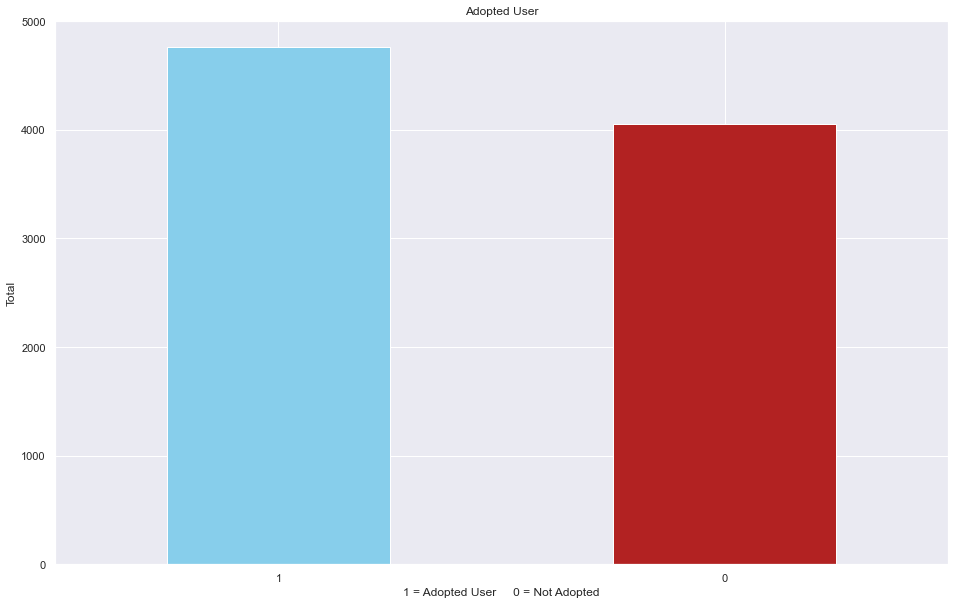

In [19]:
# Visualizing adopted user count
relax_si.adopted_user.value_counts().plot(kind="bar", color=["skyblue", "firebrick"])
plt.title("Adopted User")
plt.xlabel("1 = Adopted User     0 = Not Adopted")
plt.ylabel("Total")    
plt.xticks(rotation=0)

In [20]:
adopted_df = relax_si[relax_si['adopted_user'] == 1]
adopted_df['last_session_creation_time'] = adopted_df['last_session_creation_time'].dt.to_period('M')
adopted_df.head()

,user_id,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
creation_time,,,,,,,,,,
2012-05-31 00:43:27,3861,Jensen Stine,StineAJensen@yahoo.com,ORG_INVITE,2012-06,0,0,115,3861.0,1
2012-05-31 01:42:31,11430,Wood Levi,LeviWood@hotmail.com,ORG_INVITE,2012-06,0,0,239,5677.0,1
2012-05-31 08:20:06,10012,Spikes Danille,DanilleJSpikes@hotmail.com,ORG_INVITE,2012-05,0,1,225,7104.0,1
2012-05-31 11:55:59,11999,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,2012-06,0,0,6,NaN,1
2012-05-31 13:14:18,1995,Cardoso Rafaela,RafaelaAzevedoCardoso@hotmail.com,ORG_INVITE,2012-06,1,0,363,1995.0,1


<AxesSubplot:xlabel='creation_source', ylabel='count'>

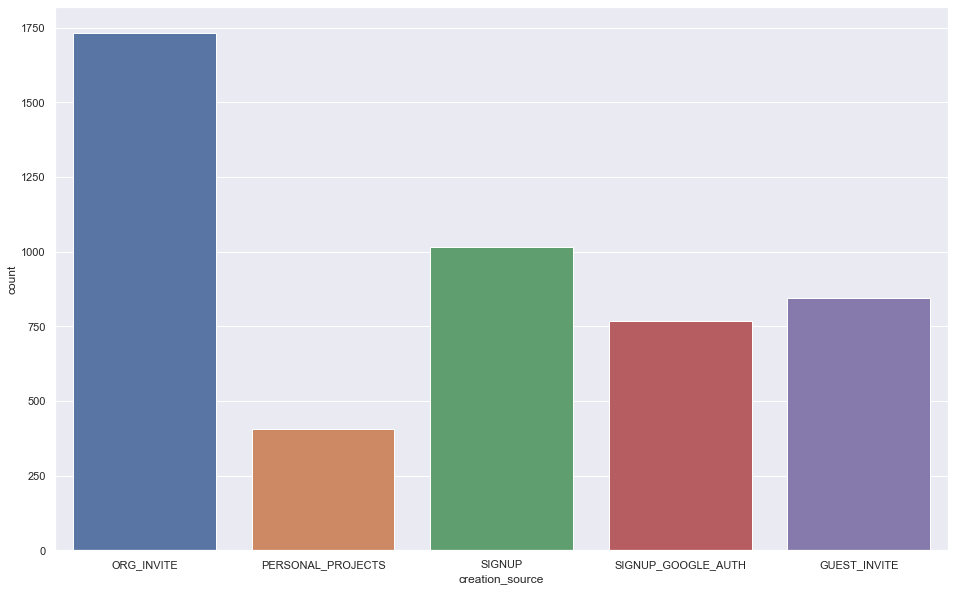

In [21]:
# Visualizing count of creation_source who are adopted users
sns.countplot(x='creation_source', data = adopted_df)

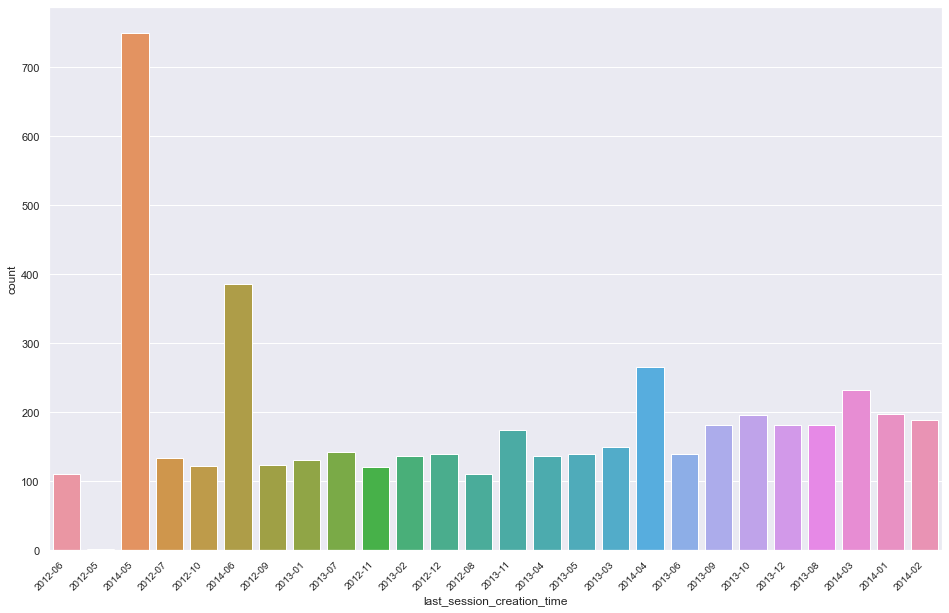

In [22]:
# Visualizing count of last_session_creation_time who are adopted users
sns.countplot(x='last_session_creation_time', data = adopted_df)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
);


#### Prepping dataframe for predictive modeling 

In [23]:
# Creating dummy variables and changing last_session_creation_time to months only
relax_prep = pd.get_dummies(relax_si, columns=['creation_source']).dropna()
relax_prep['last_session_creation_time'] = relax_prep['last_session_creation_time'].dt.month 
relax_prep.head()

,user_id,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
creation_time,,,,,,,,,,,,,,
2012-05-31 00:43:27,3861,Jensen Stine,StineAJensen@yahoo.com,6,0,0,115,3861.0,1,0,1,0,0,0
2012-05-31 01:42:31,11430,Wood Levi,LeviWood@hotmail.com,6,0,0,239,5677.0,1,0,1,0,0,0
2012-05-31 06:23:51,7170,Cavalcanti Leonardo,LeonardoPereiraCavalcanti@hotmail.com,8,0,0,145,7170.0,0,0,1,0,0,0
2012-05-31 08:20:06,10012,Spikes Danille,DanilleJSpikes@hotmail.com,5,0,1,225,7104.0,1,0,1,0,0,0
2012-05-31 13:14:18,1995,Cardoso Rafaela,RafaelaAzevedoCardoso@hotmail.com,6,1,0,363,1995.0,1,0,1,0,0,0


#### Setting up feature and target variables

In [24]:
# Feature variables
X = relax_prep.drop(['name', 'email', 'adopted_user'], axis=1)

# Target variable
y = relax_prep.adopted_user

In [25]:
# Random seed for reproducibility
np.random.seed(7)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Since this is a classification problem we will try Logistic Regression, K-Nearest Neighbors and Random Forest algorithm to see which will perform best.

In [26]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(7)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [27]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'KNN': 0.5156903765690377,
 'Logistic Regression': 0.5209205020920502,
 'Random Forest': 0.502092050209205}

Logistic Regression is the winner with a score of 52% but not really beating the other models by very much.  Let's see if we could make these better with better parameters

#### Finding KNN optimal parameters

In [28]:
# Create a list of train scores
train_scores = []

# Create a list of test scores
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1, 21) # 1 to 20

# Setup algorithm
knn = KNeighborsClassifier()

# Loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i) # set neighbors value
    
    # Fit the algorithm
    knn.fit(X_train, y_train)
    
    # Update the training scores
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores
    test_scores.append(knn.score(X_test, y_test))

Maximum KNN score on the test data: 53.14%


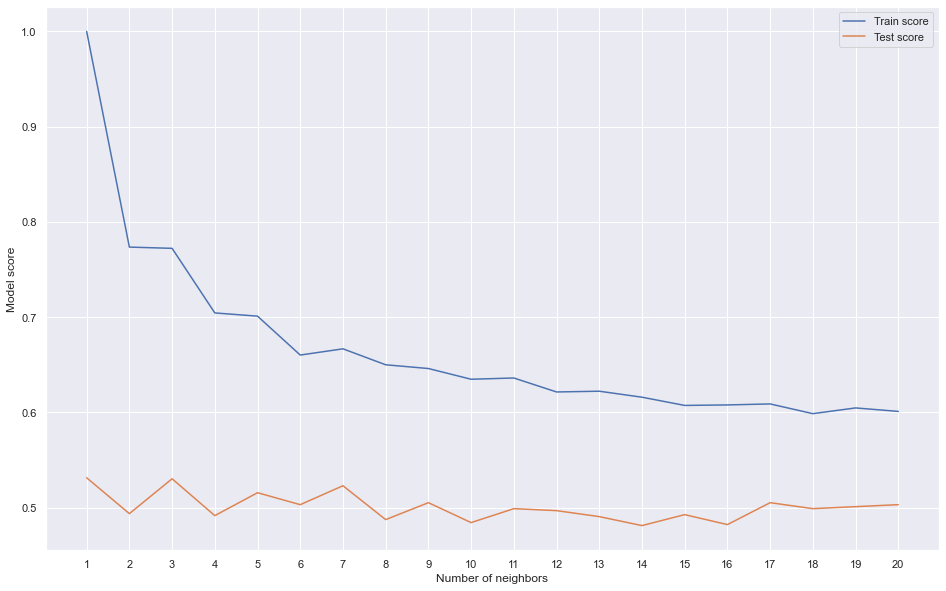

In [29]:
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

We see that max score is 53.14% at n_neighbors = 1. This is the highest so far.

#### Let's experiment and see if different hyperparameters will give a better result for Logistic Regression and Random Forest

In [30]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [31]:
# Setup random seed
np.random.seed(7)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.7s finished


In [32]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.0001}

In [33]:
lg_test_scores = rs_log_reg.score(X_test, y_test)

print(f"Maximum Logistic Regression score on the test data: {(lg_test_scores)*100:.2f}%")

Maximum Logistic Regression score on the test data: 53.77%


Logistic Regression is back on top with 53.77% with better hyperparameters.  Let's see if we can improve on Random Forest.

In [34]:
# Setup random seed
np.random.seed(7)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.7min finished


In [35]:
# Find the best parameters
rs_rf.best_params_

{'n_estimators': 510,
 'min_samples_split': 4,
 'min_samples_leaf': 9,
 'max_depth': 3}

In [36]:
# Evaluate the randomized search random forest model
rf_test_scores = rs_rf.score(X_test, y_test)

print(f"Maximum Random Forest score on the test data: {(rf_test_scores)*100:.2f}%")

Maximum Random Forest score on the test data: 53.66%


#### Using Gridsearch to Find the Best Hyperparameters

In [37]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit grid hyperparameter search model
gs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


In [38]:
# Check the best parameters
gs_log_reg.best_params_

{'C': 0.0001, 'solver': 'liblinear'}

In [39]:
# Evaluate the model
gs_log_reg.score(X_test, y_test)

0.5376569037656904

Our score hasn't improved any more.  Let's check ROC and Confusion Matrix

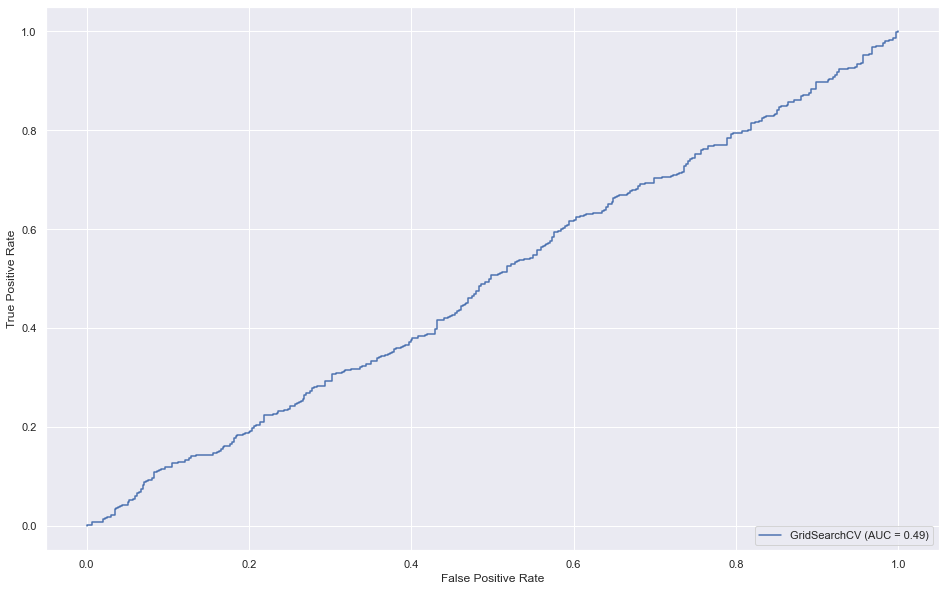

In [40]:
# Import ROC curve function from metrics module
from sklearn.metrics import plot_roc_curve

# Plot ROC curve and calculate AUC metric
plot_roc_curve(gs_log_reg, X_test, y_test);

In [41]:
y_preds = gs_log_reg.predict(X_test)

In [42]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[  3 433]
 [  9 511]]


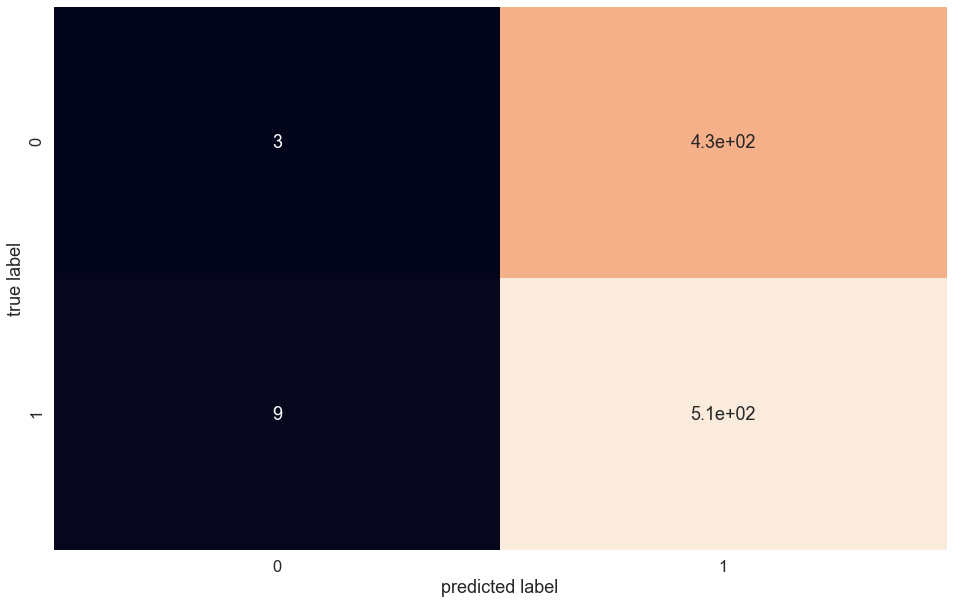

In [43]:
# Import Seaborn
import seaborn as sns
sns.set(font_scale=1.5) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots()
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    
plot_conf_mat(y_test, y_preds)

It seems that Logistic Regression fairs the best through different cross validation test.  We do our final cross validation scores.

In [44]:
# Import cross_val_score
from sklearn.model_selection import cross_val_score

# Instantiate best model with best hyperparameters (found with GridSearchCV)
clf = LogisticRegression(C=0.0001,
                         solver="liblinear")

In [45]:
# Fit an instance of LogisticRegression (taken from above)
clf.fit(X_train, y_train);
# Fit an instance of LogisticRegression (taken from above)
clf.fit(X_train, y_train);

In [46]:
# Cross-validated accuracy score
cv_acc = cross_val_score(clf, X, y,
                         cv=5, # 5-fold cross-validation
                         scoring="accuracy") # accuracy as scoring
cv_acc


array([0.5376569 , 0.52984293, 0.53926702, 0.54136126, 0.53717277])

In [47]:
cv_acc = np.mean(cv_acc)
cv_acc

0.5370601765646563

In [48]:
# Cross-validated precision score
cv_precision = np.mean(cross_val_score(clf, X, y,
                                       cv=5, # 5-fold cross-validation
                                       scoring="precision")) # precision as scoring
cv_precision

0.5389864496047209

In [49]:
# Cross-validated recall score
cv_recall = np.mean(cross_val_score(clf, X, y,
                                    cv=5, # 5-fold cross-validation
                                    scoring="recall")) # recall as scoring
cv_recall

0.9790313840596072

In [50]:
# Cross-validated F1 score
cv_f1 = np.mean(cross_val_score(clf, X, y,
                                cv=5, # 5-fold cross-validation
                                scoring="f1")) # f1 as scoring
cv_f1

0.6950141953380973

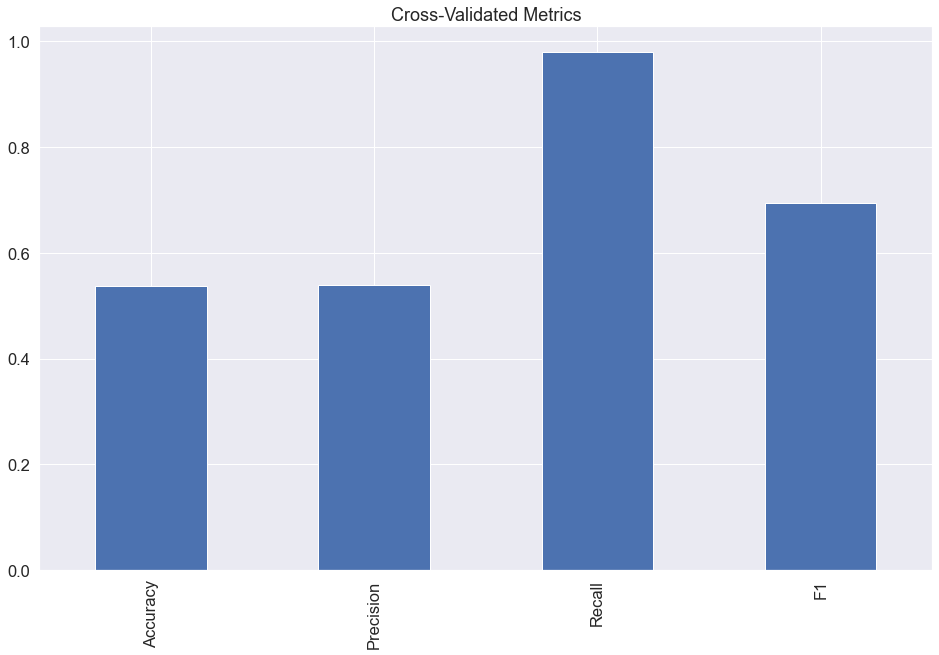

In [51]:
# Visualizing cross-validated metrics
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

Finally, let's find feature importance.

In [52]:
# Fit an instance of LogisticRegression (taken from above)
clf.fit(X_train, y_train);

In [53]:
# Check coef_
clf.coef_

array([[ 8.87209132e-06,  1.94279180e-02,  7.06230325e-04,
         2.81415145e-04, -1.28794724e-04, -3.40322794e-06,
         2.07940310e-04,  1.08069058e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [54]:
# Match features to columns
features_dict = dict(zip(X.columns, list(clf.coef_[0])))
features_dict

{'user_id': 8.872091320129856e-06,
 'last_session_creation_time': 0.019427918036586434,
 'opted_in_to_mailing_list': 0.0007062303248095274,
 'enabled_for_marketing_drip': 0.0002814151449103184,
 'org_id': -0.00012879472383256008,
 'invited_by_user_id': -3.403227940842915e-06,
 'creation_source_GUEST_INVITE': 0.00020794030961365456,
 'creation_source_ORG_INVITE': 0.0010806905846671348,
 'creation_source_PERSONAL_PROJECTS': 0.0,
 'creation_source_SIGNUP': 0.0,
 'creation_source_SIGNUP_GOOGLE_AUTH': 0.0}

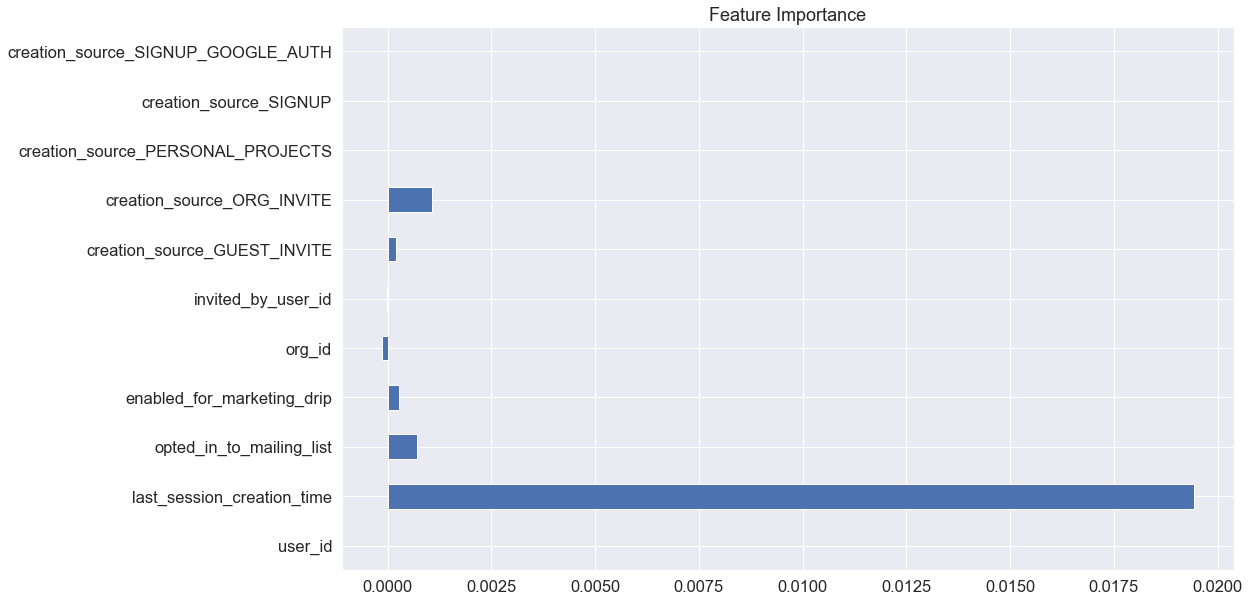

In [55]:
# Visualize feature importance
features_df = pd.DataFrame(features_dict, index=[0])
features_df.T.plot.barh(title="Feature Importance", legend=False);